In [1]:
import pandas as pd

In [5]:
df = pd.read_csv('/content/Cleaned_Reviews.csv')

In [6]:
df.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,HelpfulnessRatio,ReviewLength,ReviewDate,ReviewYear
0,B000JZYM8C,A242NQPTHNV2EN,6.0,17.0,1.0,1.185840e+09,Yuck!,This was the first Larabar product that I trie...,first larabar product tried awful bar smelled ...,0.352941,48.0,2007-07-31,2007.0
1,B005CUU23S,ADP8ROI8NMNL2,1.0,7.0,1.0,1.322525e+09,What?,This was not at all what I expected. It was li...,not expected like oldschool rollon deoderant 1...,0.142857,140.0,2011-11-29,2011.0
2,B000U96JEC,AHTZWRRB06B78,0.0,0.0,1.0,1.350950e+09,overprices and faulty weight advertiesed,Walden Farms dressings are very tasty. When I...,walden farm dressing tasty ordered said 12 12o...,0.000000,52.0,2012-10-23,2012.0
3,B004EE0TYK,AHRASE2UFPFKK,0.0,0.0,1.0,1.330214e+09,Mocha K-Cup,A little too sweet for us. However we had no p...,little sweet u however no problem swapping fri...,0.000000,59.0,2012-02-26,2012.0
4,B0002QEFEE,AZ4UBAIST96L7,0.0,0.0,1.0,1.316909e+09,Ruined our meal. Anyone actually eat this stuff?,We purhcased a can of this sauce from Walmart ...,purhcased sauce walmart make enchilada no wou...,0.000000,52.0,2011-09-25,2011.0


In [7]:
# Install necessary libraries
!pip install numpy pandas sklearn gensim

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.parsing.preprocessing import STOPWORDS

# Step 1: Ensure the correct column name
# Replace 'df' with your DataFrame variable name
reviews = df['Cleaned_Text'].dropna().tolist()

# Step 2: Sample the data to manage processing time (optional)
reviews_sampled = reviews[:20000]  # Adjust size as needed

# Step 3: Preprocessing - Tokenization, removing stopwords, and lowercasing
processed_reviews = [
    " ".join([word.lower() for word in review.split() if word.lower() not in STOPWORDS])
    for review in reviews_sampled
]

# Step 4: Convert text data into a document-term matrix with limited features
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=5000)
dtm = vectorizer.fit_transform(processed_reviews)

# Step 5: Perform LDA with parallel processing
num_topics = 5  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42, n_jobs=-1)
lda_model.fit(dtm)

# Step 6: Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 1:
coffee tea cup like taste flavor box buy good price
Topic 2:
product food ingredient buy organic company amazon jerky baby corn
Topic 3:
product box amazon order bag item ordered like received package
Topic 4:
taste like flavor product good sugar tried water bad try
Topic 5:
dog food treat cat eat product like day time bag


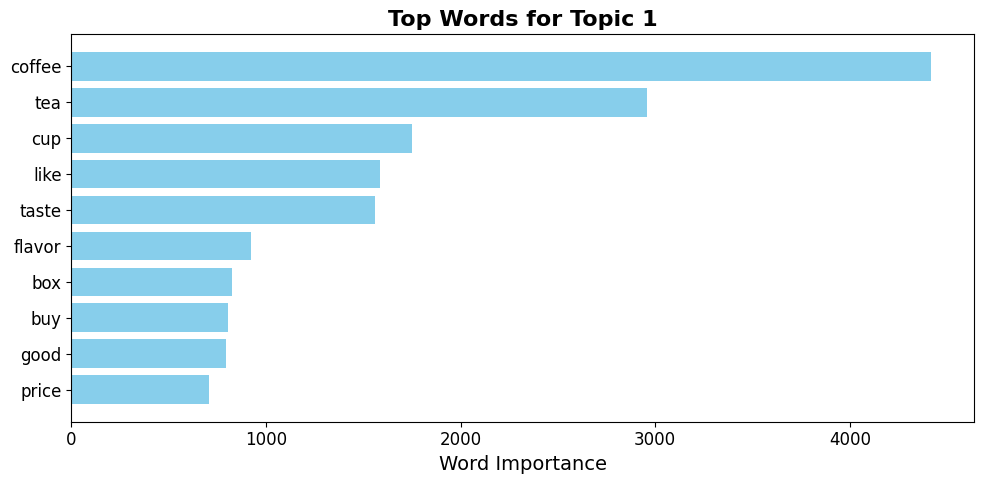

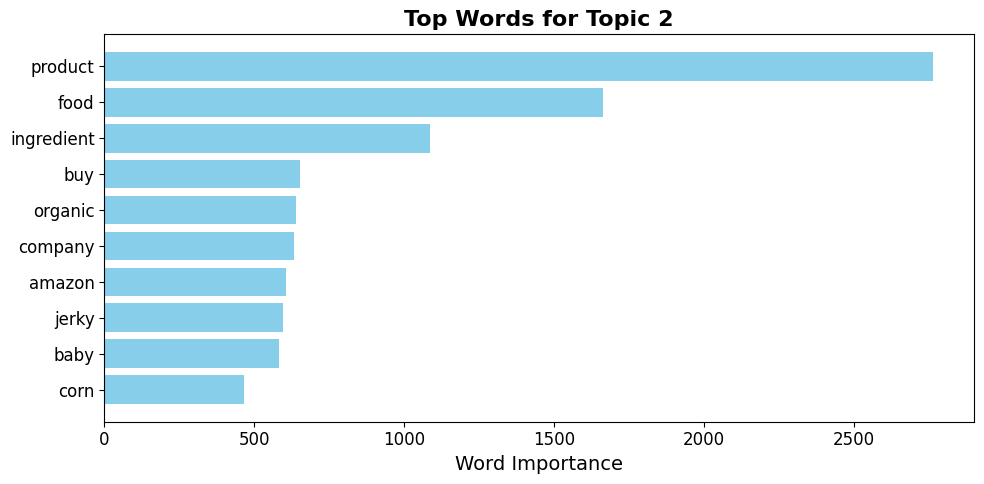

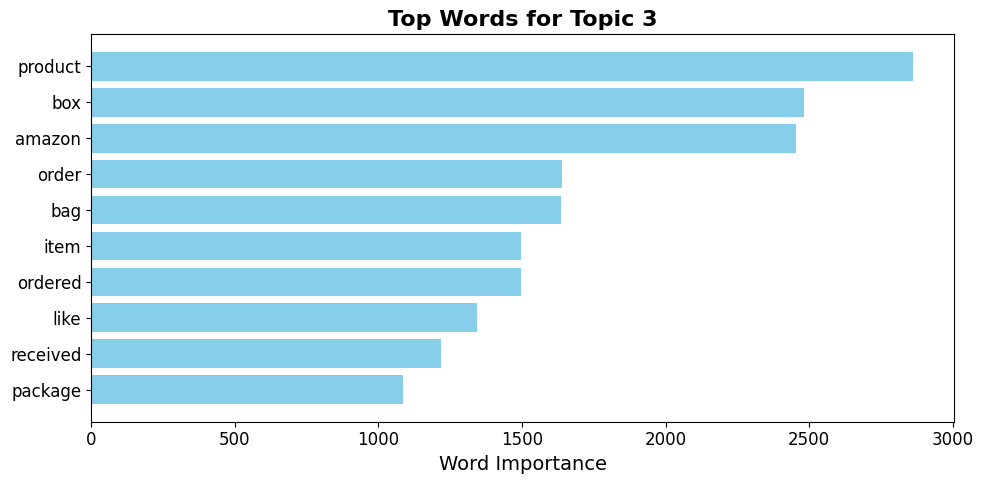

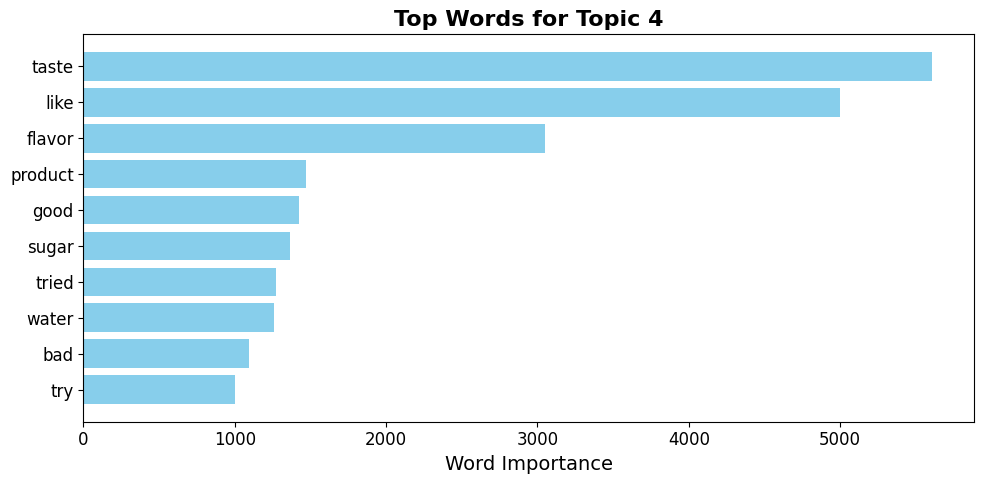

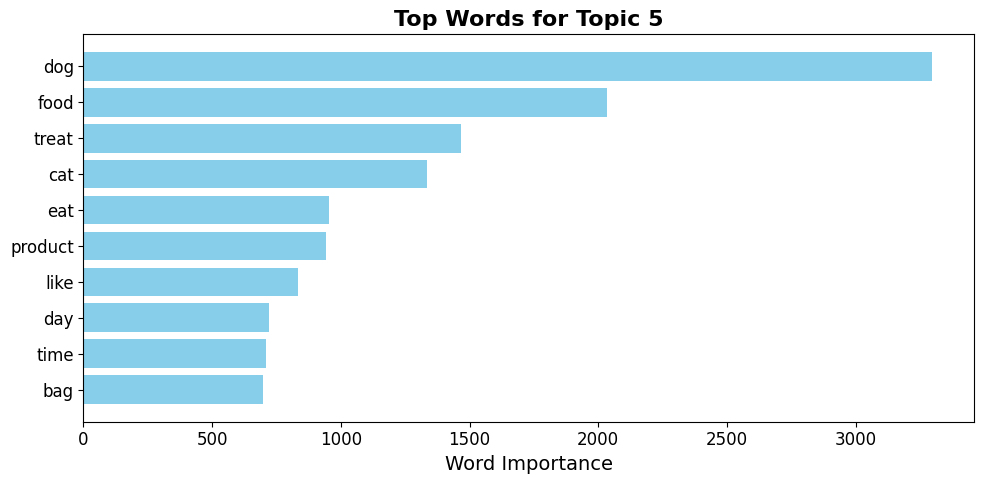

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize the top words for each topic as bar plots
def visualize_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        # Get the top words and their importance
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        top_weights = [topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

        # Create a bar plot
        plt.figure(figsize=(10, 5))
        y_pos = np.arange(len(top_words))
        plt.barh(y_pos, top_weights, color='skyblue')
        plt.yticks(y_pos, top_words, fontsize=12)
        plt.gca().invert_yaxis()  # Invert y-axis for better readability
        plt.title(f"Top Words for Topic {topic_idx + 1}", fontsize=16, fontweight='bold')
        plt.xlabel('Word Importance', fontsize=14)
        plt.tight_layout()
        plt.show()

# Call the function to visualize topics
visualize_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words=10)

In [13]:
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import pandas as pd
import nltk
from concurrent.futures import ThreadPoolExecutor

# Download necessary resources
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

reviews = df['Cleaned_Text'].dropna().sample(5000, random_state=42).tolist()  # Sample 5000 reviews

# Initialize VADER for sentiment analysis
sia = SentimentIntensityAnalyzer()

# Stopwords for filtering aspects
stop_words = set(stopwords.words('english'))

# Function to extract aspects and their sentiments
def aspect_sentiment_analysis(review):
    doc = nlp(review)
    aspects = []
    for chunk in doc.noun_chunks:
        aspect = chunk.text.lower()
        if aspect not in stop_words and len(aspect) > 1:
            sentiment = sia.polarity_scores(aspect)['compound']  # Use VADER for sentiment analysis
            aspects.append((aspect, sentiment))
    return aspects

# Use ThreadPoolExecutor to process reviews in parallel
all_aspects = []
with ThreadPoolExecutor() as executor:
    results = executor.map(aspect_sentiment_analysis, reviews)
    for res in results:
        all_aspects.extend(res)

# Convert aspects to DataFrame for analysis
aspect_df = pd.DataFrame(all_aspects, columns=["Aspect", "Sentiment"])

# Group by Aspect and calculate average sentiment
aspect_df = aspect_df.groupby("Aspect").mean().reset_index().sort_values(by="Sentiment", ascending=False)

# Display top positive and negative aspects
print("Top Positive Aspects:")
print(aspect_df.head(10))

print("\nTop Negative Aspects:")
print(aspect_df.tail(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Top Positive Aspects:
                                                  Aspect  Sentiment
9109   french roast  favorite bold distinctive flavor...     0.9545
13414  love genmai favorite japanese restaurant great...     0.9509
13487  love wolfgang puck restaurantscookwarebrand en...     0.9371
25852  wonderful medjool date perfect snacking date l...     0.9371
19558  quite good eager try product love fruity licor...     0.9368
11294     huge hit pleasant enough love mango love peach     0.9325
6746                     dog small love love treat treat     0.9300
13424  love kind bar asinb006h2jy9s kind healthy grai...     0.9287
13428                                 love love love tea     0.9274
13427            love love love sugarfree fatfree flavor     0.9274

Top Negative Aspects:
                                                  Aspect  Sentiment
26024                      wrong bitter plain disgusting    -0.8519
18203  personally not fake super sweet yucky flavorin...    -0.8545
156

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for positive aspects with a vibrant colormap
positive_aspects = dict(zip(top_positive['Aspect'], top_positive['Sentiment']))
wordcloud_positive = WordCloud(
    width=800, height=400, background_color=None, mode='RGBA', colormap='viridis',
    contour_color='black', contour_width=1
).generate_from_frequencies(positive_aspects)

# Generate word cloud for negative aspects with a contrasting colormap
negative_aspects = dict(zip(top_negative['Aspect'], abs(top_negative['Sentiment'])))
wordcloud_negative = WordCloud(
    width=800, height=400, background_color=None, mode='RGBA', colormap='coolwarm',
    contour_color='black', contour_width=1
).generate_from_frequencies(negative_aspects)


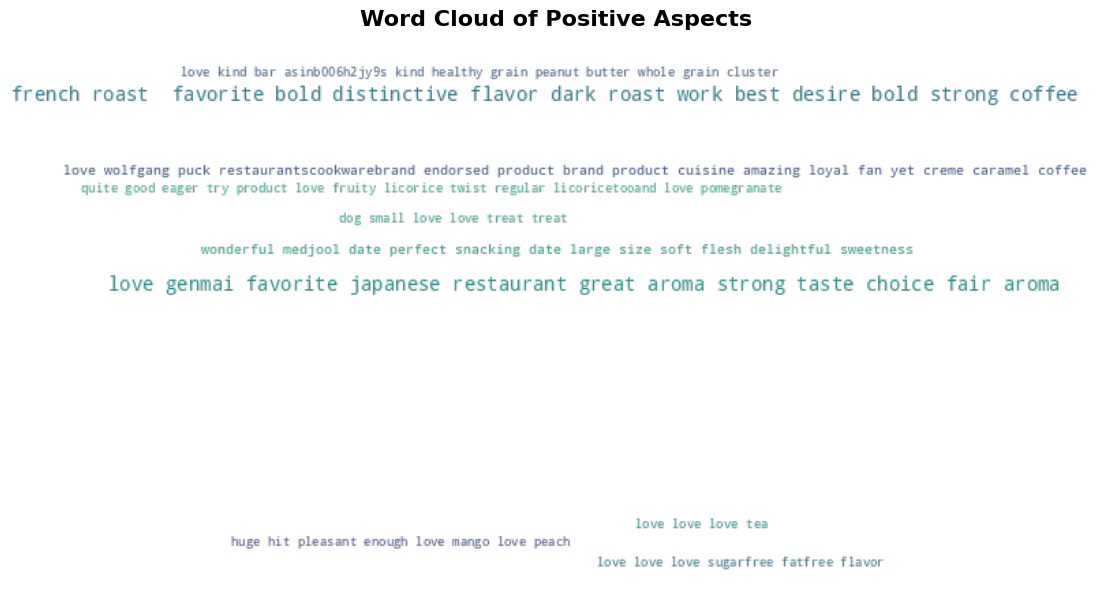

In [32]:

# Plot positive word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud of Positive Aspects', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

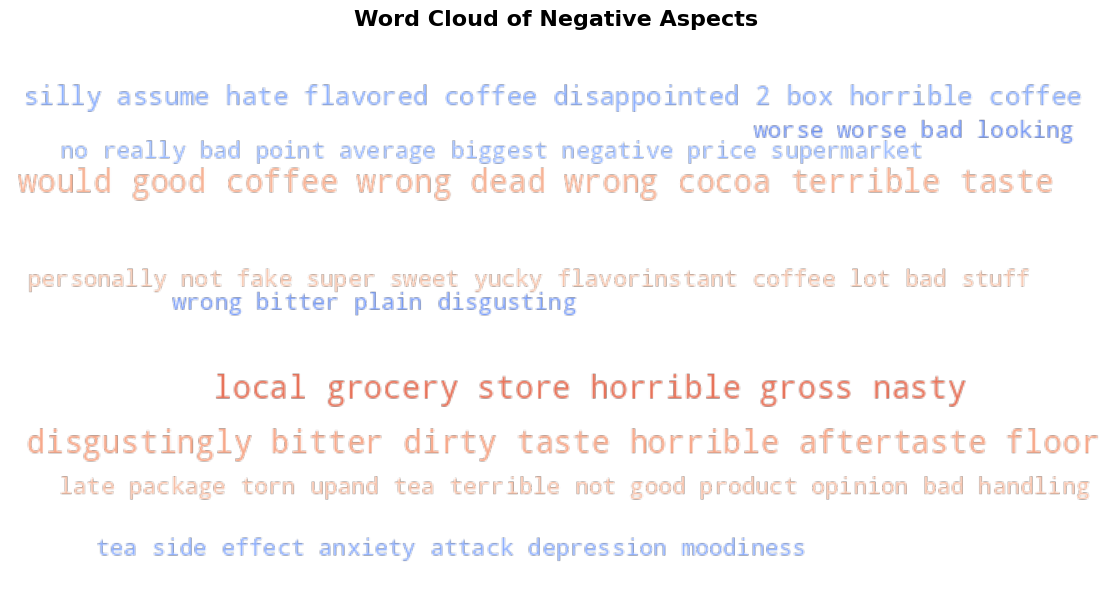

In [33]:
# Plot negative word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud of Negative Aspects', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()
